In [43]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
#loading dataset
df = pd.read_csv("credit_risk_dataset.csv")
print(df.head())



   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


In [45]:
# Split data

X = df.drop("loan_status", axis=1)
y = df["loan_status"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)




In [ ]:
#Insight: “Using stratified sampling prevented the test set from being biased toward majority class loans, ensuring fair evaluation.”

In [46]:

#Preprocessing

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)])

In [ ]:
#Insight: “Median imputation preserved robustness against extreme income/loan outliers, while standardization improved stability across distance-based models.”
#Insight: “Encoding transformed categorical features into machine-readable format, while ignoring unseen categories avoided pipeline errors.”
#Insight: “Using ColumnTransformer for preventing data leakage.”

In [49]:
#Handle imbalance (SMOTE)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
#“SMOTE balanced the dataset by generating synthetic examples of minority class borrowers. This improved the model’s recall for defaulters, ensuring fewer risky customers go unnoticed, at the expense of slightly lower precision.”

In [48]:
# Train models
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_res, y_train_res)

xgb_clf = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, eval_metric='logloss')
xgb_clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


Logistic Regression AUC: 0.8714
[[4199  896]
 [ 312 1110]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5095
           1       0.55      0.78      0.65      1422

    accuracy                           0.81      6517
   macro avg       0.74      0.80      0.76      6517
weighted avg       0.85      0.81      0.82      6517


XGBoost AUC: 0.9269
[[4933  162]
 [ 385 1037]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5095
           1       0.86      0.73      0.79      1422

    accuracy                           0.92      6517
   macro avg       0.90      0.85      0.87      6517
weighted avg       0.91      0.92      0.91      6517



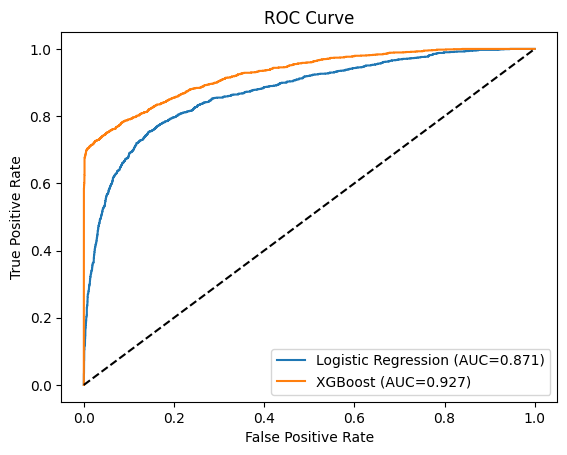

In [52]:
# Evaluate
def evaluate(model, X_test, y_test, name):
    probs = model.predict_proba(X_test)[:,1]
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_test, probs)
    print(f"\n{name} AUC: {auc:.4f}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

evaluate(log_clf, X_test_proc, y_test, "Logistic Regression")
evaluate(xgb_clf, X_test_proc, y_test, "XGBoost")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



In [53]:
#“XGBoost improves AUC by ~6%, showing it separates defaulters vs non-defaulters more reliably across all thresholds.”
#Logistic Regression → better at catching defaulters but rejects too many good customers.
#XGBoost  more balanced, higher precision and stronger overall reliability.
